In [1]:
# Load all dependencies
# transformers: huggingface tool to download pretrained models, tokenizers, and datasets
! pip install jsonlines
! pip install transformers 
! pip install datasets
! pip install peft
! pip install rouge_score
! pip install -U accelerate
! pip install numpy
! pip install pandas
! pip install scikit-learn
! pip install torch
! pip install seaborn
! pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip insta

In [2]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
# determines whether CUDA GPU or CPU is used
device = ('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))
print(device)

mps


In [4]:
# import ROBERTA tokenizer from HUGGINGFACE (transformers library is developed by HUGGINGFACE)
from transformers import AutoTokenizer

model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

**Creating and Cleaning Dataset**

In [5]:
# dataset from HUGGINGFACE contains train, test, and validation datasets
from datasets import load_from_disk, load_dataset

# Use dataset I put into hugging face
dataset = load_dataset('bigbio/hallmarks_of_cancer')
dataset.remove_columns('document_id')

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 12119
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3547
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1798
    })
})

In [6]:
# load train, test, and validation datasets into pandas individually and concat into unified dataframe
import pandas as pd

new_df1 = pd.DataFrame(dataset['train'])
new_df2 = pd.DataFrame(dataset['validation'])
new_df3 = pd.DataFrame(dataset['test'])

new_df = pd.concat([new_df1, new_df2, new_df3])
new_df.drop(['document_id'], axis=1, inplace=True)
new_df

,text,label
0,Hypoxic events frequently occur in the aquatic...,[7]
1,Only a few studies are however available on th...,[7]
2,"To elucidate the phenomenon , mirror carp Cypr...",[7]
3,( 16.13-16.22 g ) were exposed chronically to ...,[7]
4,Level of oxidative DNA damage ( as determined ...,[7]
...,...,...
3542,"After repeated in vivo passages , a subline wa...",[5]
3543,These cells were characterized by increased in...,[1]
3544,"Furthermore , the increased metastatic ability...",[5]
3545,When cultured in vitro for a prolonged time ( ...,[5]


In [7]:
new_df['label'].value_counts()

[7]              13010
[9]                669
[6]                621
[4]                566
[5]                509
                 ...  
[1, 10, 6, 2]        1
[1, 10, 6]           1
[9, 5, 6]            1
[9, 6, 0, 4]         1
[10, 5, 4]           1
Name: label, Length: 87, dtype: int64

In [8]:
nums = set()
nums_dict = {}
for i in range(len(new_df)):
  output = new_df.iloc[i][1] #row i column 1 (label)
  for n in output:
    nums.add(n)
    nums_dict[n] = nums_dict.get(n, 0) + 1

print(nums) #every unique number in dataset (labels)
print(nums_dict) #count of each basic label

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
{7: 13010, 10: 226, 4: 832, 8: 358, 9: 993, 5: 667, 6: 768, 1: 518, 3: 213, 0: 366, 2: 295}


In [9]:
for i in range(len(new_df)):
  output = new_df.iloc[i, 1]
  one_hot_output = [0] * 11 #initialize array storing 11 0's
  for n in output:
    one_hot_output[n] = 1 #convert VALUE array into standard size of 11 ints

  new_df.iloc[i][1] = one_hot_output

In [10]:
new_df.head()

,text,label
0,Hypoxic events frequently occur in the aquatic...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
1,Only a few studies are however available on th...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,"To elucidate the phenomenon , mirror carp Cypr...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
3,( 16.13-16.22 g ) were exposed chronically to ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,Level of oxidative DNA damage ( as determined ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


In [11]:
new_df.tail()

,text,label
3542,"After repeated in vivo passages , a subline wa...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3543,These cells were characterized by increased in...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3544,"Furthermore , the increased metastatic ability...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3545,When cultured in vitro for a prolonged time ( ...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
3546,These results indicate that metastatic ability...,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


In [12]:
for i, data in enumerate(new_df['text'], 0):
    if new_df.iloc[i][1] != [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]:
        print(f'text: \'{data}\', label: {new_df.iloc[i][1]}, row: {i}')
        break

text: 'There was no evidence of immunosuppression .', label: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], row: 22


In [13]:
# Create balanced dataset

# mark MAJORITY_CLASS data
only = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] #important value that indicates MAJORITY_CLASS
flag = [] #flag every row that equals the value in ONLY, represents MAJORITY_CLASS
for i in range(len(new_df)):
  o = new_df.iloc[i, 1] #get value for each row
  if o == only:
    flag.append(1)
  else:
    flag.append(0)

# create new column for this new value that indicates a MAJORITY_CLASS
new_df['majority_class'] = flag

# Find the rows corresponding to the majority class
majority = new_df[new_df['majority_class']==1]
minority = new_df[new_df['majority_class']==0]

# random sampling because majority class is as large/larger than every minority class combined
sample_size = 1000  #Determine the number of rows you want to sample from the majority class
sampled = majority.sample(n=sample_size) #Perform random sampling

# create unified dataframe that combines sampled majority and every minority in dataset
df = pd.concat([sampled, minority])

# reset index of each row, to account for concatenation
df = df.reset_index(drop=True)

# remove MAJORITY_CLASS column from dataframe
df.drop(columns=['majority_class'], axis=1, inplace=True)


In [14]:
len(df)

5454

In [15]:
complexrownums = []
for testnum, row in enumerate(df['label']):
    s = 0
    for num in row:
        if num == 1:
            s += 1
    if s > 1:
        complexrownums.append(testnum)

for num in complexrownums:
    print(df.iloc[num])

text     RESULTS In the limited number of cases in whic...
label                    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]
Name: 1009, dtype: object
text     Fas receptor expression was high in normal muc...
label                    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Name: 1010, dtype: object
text     Apoptosis was more abundant in primary tumours...
label                    [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Name: 1011, dtype: object
text     CONCLUSIONS These results demonstrate that pro...
label                    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Name: 1012, dtype: object
text     Further , autophagy and subsequent cell growth...
label                    [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Name: 1018, dtype: object
text     Knockdown of SIRT6 increased the expression of...
label                    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]
Name: 1025, dtype: object
text     Taken together , these results demonstrate tha...
label                    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]
Name: 1026, dtype:

In [16]:
# uses tokenizer initialized in the beginning to tokenize the data in the dataset
max_tokens = 0

for sentence in df['text']: #each sentence is the text in each row, which consists of a sentence
    tokens = tokenizer.tokenize(sentence) #Tokenize the sentence
    num_tokens = len(tokens) #Count the tokens in the sentence
    max_tokens = max(max_tokens, num_tokens) #Update the maximum token count if necessary

print("Maximum number of tokens in the sentences:", max_tokens)

Maximum number of tokens in the sentences: 192


In [17]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256 #max length for input data
TRAIN_BATCH_SIZE = 8 #size of batches of data
VALID_BATCH_SIZE = 4 #size of batches of data
EPOCHS = 5 #number of passes through dataset
LEARNING_RATE = 1e-05

# '''
# larger batch sizes train faster and have more stable updates to model weight
# larger batch sizes use more memory and can lead to slower convergence/divergence
# '''

In [18]:
from torch.utils import data

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe['text']
        self.targets = dataframe['label']
        self.max_len = max_len

    def __len__(self):
      return len(self.comment_text)

    def __getitem__(self, index):
        # split and rejoin sentence to standardize whitespace
        comment_text = str(self.comment_text[index])
        comment_text = " ".join(comment_text.split())

        inputs = self.tokenizer.encode_plus(
            comment_text, #text data in dataframe
            None, #no second input
            add_special_tokens=True, #increases accuracy
            max_length=self.max_len, #max input
            # truncation=True,
            pad_to_max_length=True, #standardizes input length
            return_token_type_ids=True #returns token ids
        )

        '''
        inputs returns
        input_ids: list of token ids that represent input text
        attention_mask: determine which tokens are input and which are padding
        token_type_ids: token type IDs that differentiate between different segments of text
        '''

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        # return dictionary with tensor arrays containing ids, mask, token types, and targets (values)
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [19]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8 #proportion of dataset that will be used for training
train_dataset=df.sample(frac=train_size,random_state=200).reset_index(drop=True) #sample dataframe for training
test_dataset=df.drop(train_dataset.index).reset_index(drop=True) #test dataframe excludes rows for training and resets index
# train_dataset = train_dataset.reset_index(drop=True)

# df.shape returns dimentions of dataframe: row, col
print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (5454, 2)
TRAIN Dataset: (4363, 2)
TEST Dataset: (1091, 2)


In [20]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

# '*var' in function call unpacks list into positional arguments
# '**var' in function call unpacks dictionary into keyword arguments
training_loader = DataLoader(training_set, **train_params) #loads data into model for training
testing_loader = DataLoader(testing_set, **test_params) #loads data into model for testing

In [21]:
from transformers import AutoTokenizer, RobertaModel

model = RobertaModel.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
from transformers import RobertaModel
import torch

class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base") #layer 1 has roberta model
        self.drop = torch.nn.Dropout(0.3) #layer 2 deactivates (drops out) .30 of neurons while training
        self.linear = torch.nn.Linear(768, 11) #weight matrix and bias vector

        # self.drop2 = torch.nn.Dropout(0.3) #layer 2 deactivates (drops out) .30 of neurons while training
        # self.linear2 = torch.nn.Linear(128, 11) #weight matrix and bias vector

    def forward(self, ids, mask, token_type_ids): #run model
        _, output_1 = self.roberta(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        output_2 = self.drop(output_1)
        output = self.linear(output_2)

        #test
        # output3 = self.drop2(output)
        # output4 = self.linear2(output3)
        
        return output

model = RoBERTaClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaClass(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerN

In [23]:
def loss_fn(outputs, targets): #loss function
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [24]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

VALIDATION

In [25]:
# import pretrained model if not first time
model = RoBERTaClass().to(device)
# model.load_state_dict(torch.load('enhance_cancer.pth'))
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
import matplotlib.pyplot as plt

def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [27]:
from tqdm import tqdm
import matplotlib.pyplot as plt

#loop = tqdm(training_loader)
loss_vals = []
epoch_loss = 0
for epoch in range(EPOCHS):
    model.train()
    for i ,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = torch.nn.BCEWithLogitsLoss()(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        #epoch_loss += loss.item()
        optimizer.step()
        loss_vals.append(loss.item())
    #loss_vals.append(epoch_loss / (epoch + 1))

    print(f'Epoch: {epoch}, Loss:  {loss.item()}')
    # Load progress bar
    #loop.set_description(f"Epoch [{epoch}/{EPOCHS}]")
    #loop.set_postfix(loss=torch.rand(1).item(), acc=torch.rand(1).item())
# my_plot(np.linspace(1, EPOCHS, EPOCHS).astype(int), loss_vals)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/shippai/.pyenv/versions/3.11.1/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  0.7211050987243652
Epoch: 1, Loss:  0.7165461778640747
Epoch: 2, Loss:  0.7212879657745361
Epoch: 3, Loss:  0.707911491394043
Epoch: 4, Loss:  0.7140735983848572


In [28]:
def validation():
    model.eval() #set model to evaluation mode
    fin_targets=[] #target list
    fin_outputs=[] #predict list
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0): #iterate over rows loaded in testing dataset (through dataloader)
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [29]:
outputs, targets = validation()
outputs = np.array(outputs) >= 0.5
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.0
F1 Score (Micro) = 0.19984627209838585
F1 Score (Macro) = 0.11247726368040385


/Users/shippai/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [30]:
# save model
torch.save(model.state_dict(), 'enhance_cancer.pth')

In [31]:
import matplotlib.pyplot as plt
import itertools

# create confusion matrix
def plot_confusion_matrix(cm,                       #confusion matrix
                          target_names=[0, 1],      #list of labels
                          title='Title',            #title of graph
                          color='Blues',            #colormap for visuals
                          normalize=False):          #normalized = proportions
    
    # convert list to numpy array
    cm = np.asarray(cm)
    
    # find accuracy
    accuracy = np.trace(cm) / float(np.sum(cm))     #trace sums diagonals of cm, dividing by total sum gets accuracy
    misclass = 1 - accuracy                         #inaccuracy

    # get color map
    cmap = plt.get_cmap(color)

    # display plot
    plt.figure(figsize=(8, 6))                      #physical size of the plot
    plt.imshow(cm,                                  #display plot
               interpolation='nearest', 
               cmap=cmap) 
    plt.title(title)                                #show title of plot
    plt.colorbar()                                  #enable color bar

    # shows 'ticks' or label values on axes of plot
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, 
               rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, 
                 ("{:0.4f}".format(cm[i, j]) if normalize else "{:,}".format(cm[i, j])), 
                 horizontalalignment="center", 
                 color="white" if i == 0 and j == 0 else "black")


    plt.tight_layout()
    plt.ylabel('Target Label')
    plt.xlabel('Predicted Label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

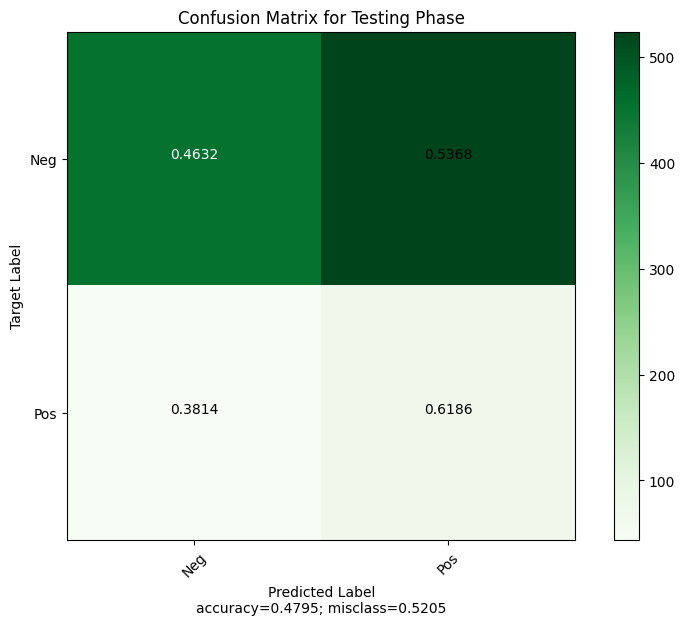

In [32]:
from sklearn import metrics

# create and process confusion matrix
c_matrix = metrics.multilabel_confusion_matrix(targets, outputs, labels=range(11))
fin_c_matrix = [[0, 0],
                [0, 0]]

# aggregate all confusion matrices
for _, mat in enumerate(c_matrix):
    for n in range(2):
        for m in range(2):
            fin_c_matrix[n][m] += mat[n][m]

# average sum of all confusion matrices
for n in range(2):
    for m in range(2):
        # 11 confusion matrices
        fin_c_matrix[n][m] /= 11

# visualize confusion matrix (as numpy array) with function
plot_confusion_matrix(fin_c_matrix,
                      target_names=['Neg', 'Pos'],
                      color='Greens',
                      title='Confusion Matrix for Testing Phase',
                      normalize=True)


INFERENCE

In [33]:
# # inference input with model
# def inference(input_text):
#     inference_dataset = pd.DataFrame({'text': [input_text], 'label': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]})
#     inference_set = CustomDataset(inference_dataset, tokenizer=tokenizer, max_len=MAX_LEN)
#     inference_loader = DataLoader(inference_set, batch_size=1, shuffle=False)
    
#     # model should be set to eval
#     with torch.no_grad():
#         for data in inference_loader:
#             ids = data['ids'].to(device, dtype=torch.long)
#             mask = data['mask'].to(device, dtype=torch.long)
#             token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
#             final_output = model(ids, mask, token_type_ids)
#     return final_output

In [34]:
# import pandas as pd

# model = RoBERTaClass().to(device)
# model.load_state_dict(torch.load('enhance_cancer.pth'))
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# input_text = input('Express your symptoms in a sentence:')
# # input_text = 'There was no evidence of immunosuppression.'

# # pass inputs onto model
# model.eval()
# final_output = inference(input_text)

# predictions = torch.nn.functional.softmax(final_output, dim=1)
# predicted_classes = torch.argmax(predictions, dim=1)
# print(f'output: {predicted_classes}')

